# Task 1: Training a Cheater

Now I'm going to train the smallest CNN I can get away with and see if it actually learns to read digits... or just learns to read colors.


In [238]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(0, "..")

import importlib
import src.data.colored_mnist, src.data.datasets, src.data
import src.models.cnn, src.models.registry
for m in [src.data.colored_mnist, src.data.datasets, src.data, src.models.cnn, src.models.registry]:
    importlib.reload(m)

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from src.data.datasets import get_dataloaders, load_split
from src.data.colored_mnist import PALETTE, colorize_with_background, COLOR_NAMES, make_dominant_color_map
from src.models.registry import build_model
from src.utils.seed import seed_everything, SeedConfig

In [239]:
SEED = 42
seed_everything(SeedConfig(seed=SEED))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


In [240]:
loaders = get_dataloaders({"root": "../data/colored_mnist", "batch_size": 128, "num_workers": 2})
for k, v in loaders.items():
    print(f"{k}: {len(v.dataset)}")

train: 54000
val: 6000
test_hard: 10000


## The Model


In [241]:
model = build_model({"name": "simple_cnn", "width": 4}).to(device)
print(model)
print(f"\n{sum(p.numel() for p in model.parameters()):,} params")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=392, out_features=10, bias=True)
  )
)

4,486 params


## Training


In [242]:
def train_epoch(model, loader, opt):
    model.train()
    total_loss, correct, n = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = F.cross_entropy(out, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        n += x.size(0)
    return total_loss / n, correct / n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct, n = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        correct += (model(x).argmax(1) == y).sum().item()
        n += x.size(0)
    return correct / n

In [243]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
history = []
best_val, best_state = 0, None

for epoch in range(1, 6):
    loss, train_acc = train_epoch(model, loaders["train"], opt)
    val_acc = evaluate(model, loaders["val"])
    history.append({"epoch": epoch, "train": train_acc, "val": val_acc})
    print(f"ep {epoch}: train={train_acc:.3f} val={val_acc:.3f}")
    if val_acc > best_val:
        best_val, best_state = val_acc, model.state_dict().copy()

/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 1: train=0.835 val=0.946


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 2: train=0.953 val=0.946


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 3: train=0.953 val=0.947


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 4: train=0.955 val=0.950


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

ep 5: train=0.959 val=0.955


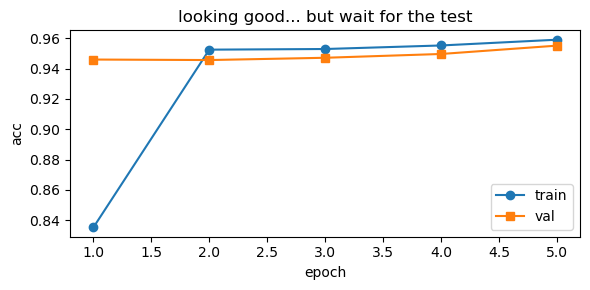

In [244]:
plt.figure(figsize=(6, 3))
plt.plot([h["epoch"] for h in history], [h["train"] for h in history], "o-", label="train")
plt.plot([h["epoch"] for h in history], [h["val"] for h in history], "s-", label="val")
plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend()
plt.title("looking good... but wait for the test")
plt.tight_layout()
plt.show()

## The Moment of Truth

OK so train and val both look great — 96% and 95.5%. If this were a homework assignment you'd submit it and go get lunch. But let's see what happens on test_hard, where the colors are *randomly* assigned so the shortcut is worthless.


In [245]:
model.load_state_dict(best_state)

train_acc = evaluate(model, loaders["train"])
val_acc = evaluate(model, loaders["val"])
test_acc = evaluate(model, loaders["test_hard"])

print(f"Train:     {train_acc:.1%}")
print(f"Val:       {val_acc:.1%}")
print(f"Test Hard: {test_acc:.1%}")
print()
if test_acc < 0.2:
    print("yep, it's cheating. learned color instead of shapes.")

# save for task 3 (gradcam)
import os
os.makedirs("../outputs", exist_ok=True)
torch.save(best_state, "../outputs/baseline_model.pt")
print(f"\\nsaved model to outputs/baseline_model.pt")

/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Train:     96.1%
Val:       95.5%
Test Hard: 22.4%

\nsaved model to outputs/baseline_model.pt


## Confusion Matrix on Test Hard

**22.4%.** Ooof. That's barely above chance (which would be 10% for 10 classes). Look at all that off-diagonal noise — the model isn't systematically confusing similar-looking digits (like 3s and 8s). It's just... guessing. The few correct predictions that do land on the diagonal are mostly coincidence. The loudest signal in this matrix is the model's confusion, not its knowledge.


/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/lohithkola/miniconda3/envs/lazy-artist/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

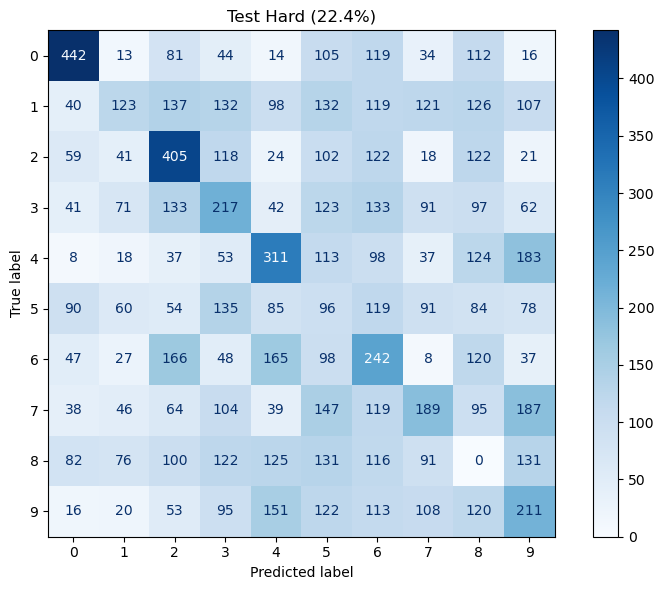

In [246]:
@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    ys, preds = [], []
    for x, y in loader:
        preds.append(model(x.to(device)).argmax(1).cpu())
        ys.append(y)
    return torch.cat(ys), torch.cat(preds)

y_true, y_pred = get_preds(model, loaders["test_hard"])
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"Test Hard ({test_acc:.1%})")
plt.tight_layout()
plt.show()

## The Smoking Gun: Same Digit, Different Colors

Take a single digit — a "1" — and slap it onto all 10 background colors. If the model actually learned what a "1" looks like, it should say "1" every single time regardless of the background. If it learned colors instead... well.


In [247]:
from torchvision.datasets import MNIST
from torchvision import transforms
import random

mnist = MNIST("../data/colored_mnist/_mnist_cache", train=False, download=False)

# grab a "1"
for img, lbl in mnist:
    if lbl == 1:
        gray_1 = transforms.ToTensor()(img).squeeze()
        break

print("got a 1")

got a 1


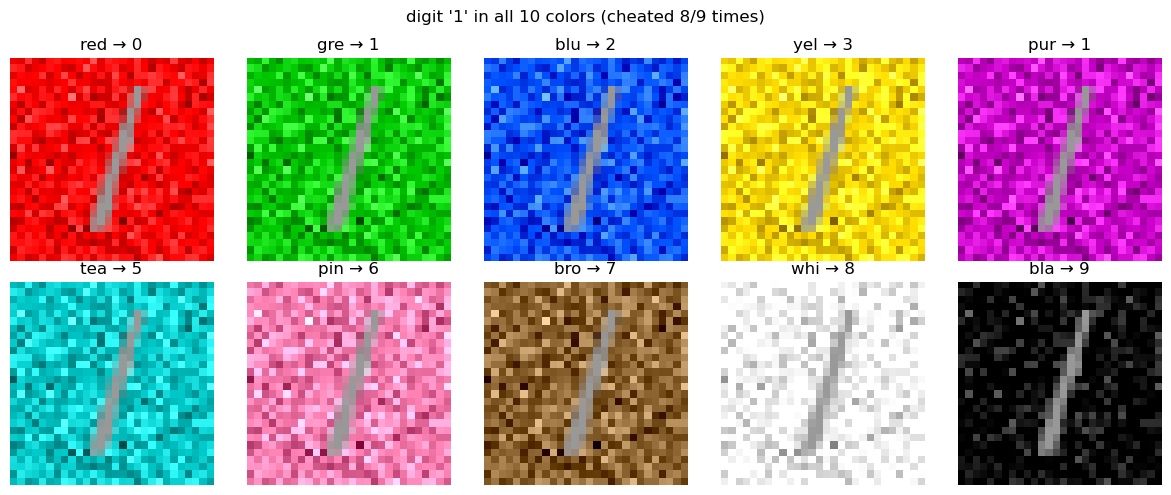

In [248]:
def test_color(gray, color_idx):
    rng = random.Random(42)
    # monochrome: digit and background are same color
    colored = colorize_with_background(gray, PALETTE[color_idx], (255, 255, 255), noise_std=0.15, rng=rng)
    with torch.no_grad():
        logits = model(colored.unsqueeze(0).to(device))
        pred = logits.argmax(1).item()
    return colored, pred

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
cheated = 0
for i in range(10):
    colored, pred = test_color(gray_1, i)
    axes[i//5, i%5].imshow(colored.permute(1,2,0).numpy())
    axes[i//5, i%5].set_title(f"{COLOR_NAMES[i][:3]} → {pred}")
    axes[i//5, i%5].axis("off")
    if pred == i and pred != 1:
        cheated += 1

plt.suptitle(f"digit '1' in all 10 colors (cheated {cheated}/9 times)")
plt.tight_layout()
plt.show()

It cheated **8 out of 9 times**. Red background → predicts 0. Blue → 2. Yellow → 3. Teal → 5. Pink → 6. Brown → 7. White → 8. Black → 9. The *only* time it said "1" was on the green background — which is not because it recognized the digit, it's because green = 1 in the training data. Even purple got predicted as 1, which *technically* looks right but it's just the model being slightly confused between similar-ish colors.

Below: the red case isolated. A perfectly clear digit "1" on a red background. The model says "0" with ~46% confidence, with class 1 trailing at ~40%. It is literally *looking at* a one and saying "nah, that's a zero" because red = 0.

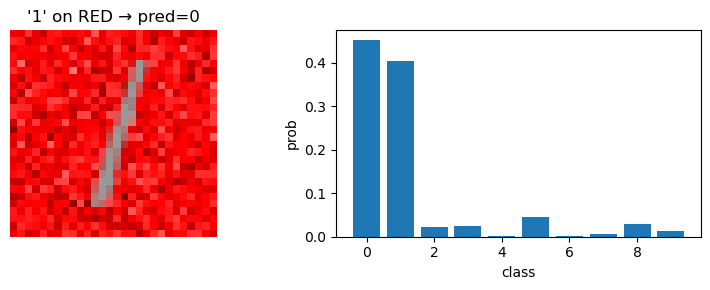

confirmed: it predicted 0 because of the red background, not the digit shape


In [249]:
# the key test
colored_red, pred_red = test_color(gray_1, 0)  # red = color 0

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(colored_red.permute(1,2,0).numpy())
axes[0].set_title(f"'1' on RED → pred={pred_red}")
axes[0].axis("off")

with torch.no_grad():
    probs = F.softmax(model(colored_red.unsqueeze(0).to(device)), dim=1)[0].cpu()
axes[1].bar(range(10), probs.numpy())
axes[1].set_xlabel("class"); axes[1].set_ylabel("prob")

plt.tight_layout()
plt.show()

if pred_red == 0:
    print("confirmed: it predicted 0 because of the red background, not the digit shape")

## So What Just Happened?

| Split | Accuracy |
|-------|----------|
| Train | 96.1% |
| Val | 95.5% |
| Test Hard | **22.4%** |

That gap is the entire story. 96% when the color-shortcut is present, 22% when it's removed. The model didn't learn digit recognition — it learned a lookup table: background color → class label.

Think about it from the model's perspective: why would you bother learning to trace the curves of a "3" or count the loops in an "8" when you can just average the pixel values and get a single number that's right 95% of the time? Color is a *way* cheaper feature. It fills the entire 28×28 image uniformly. The digit itself is this tiny grey squiggle covering maybe 15-20% of the pixels. Of course the model goes for the easy signal.

The 22.4% is actually interesting though — it's above the 10% random baseline, which means the network picked up *a little* bit of shape information along the way. Not much, but not zero.
